### **Introdução às LSTMs (Long Short-Term Memory)**

As redes LSTM (Long Short-Term Memory) são um tipo especial de RNN projetada para lidar com o problema de dependências de longo prazo em sequências de dados. Elas são amplamente utilizadas em tarefas de processamento de linguagem natural, reconhecimento de fala, e outras aplicações que envolvem sequências.

#### **Por que LSTMs?**

Em RNNs tradicionais, o problema de desvanecimento de gradientes pode dificultar o aprendizado de dependências de longo prazo. As LSTMs resolvem esse problema através de uma arquitetura de memória mais complexa, que inclui células de memória capazes de preservar informações ao longo de várias etapas de tempo.

#### **Arquitetura de uma LSTM**

As LSTMs introduzem três "portas" (gates) principais para controlar o fluxo de informações:
- **Porta de Entrada (Input Gate)**: Controla quanta informação da entrada atual deve ser armazenada na célula de memória.
- **Porta de Esquecimento (Forget Gate)**: Decide quanta informação da célula de memória anterior deve ser mantida.
- **Porta de Saída (Output Gate)**: Controla quanta informação da célula de memória deve ser utilizada para produzir a saída atual.

Matematicamente, a atualização de uma célula LSTM pode ser descrita pelas seguintes equações:

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$
$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t \cdot \tanh(C_t)
$$

Onde:
- $f_t$, $i_t$, $o_t$ são as portas de esquecimento, entrada e saída, respectivamente.
- $C_t$ é o estado da célula.
- $h_t$ é o estado oculto.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### **Primeiros Passos com LSTM - Entradas Aleatórias**

Vamos começar criando uma LSTM simples e alimentá-la com entradas aleatórias. Isso nos ajudará a entender como a LSTM processa os dados e o formato das saídas.

#### **Explicação do Código**

- **`nn.LSTM`**: Implementa uma LSTM básica com uma ou mais camadas.
- **Parâmetros principais**:
  - `input_size`: Dimensão das entradas em cada passo de tempo.
  - `hidden_size`: Número de unidades na célula LSTM.
  - `num_layers`: Número de camadas empilhadas de LSTM.
  - `batch_first=True`: Faz com que o batch seja a primeira dimensão no tensor de entrada.

In [10]:
# Configurações
input_size = 5  # Tamanho da entrada em cada passo de tempo
hidden_size = 10  # Número de unidades na camada oculta
num_layers = 2  # Número de camadas empilhadas

# Criando uma LSTM
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

In [14]:
# Criando uma entrada aleatória: (batch_size, seq_len, input_size)
batch_size = 8
seq_len = 7
x = torch.randn(batch_size, seq_len, input_size)

# Executando a LSTM
output, (hn, cn) = lstm(x)

### **Interpretação das Saídas da LSTM**

Vamos analisar o que as diferentes saídas da LSTM significam:

- **`output`**: Contém a saída de cada passo de tempo para cada sequência no batch. A forma será `(batch_size, seq_len, hidden_size)`.
- **`hn`**: O estado oculto final para cada camada e cada sequência no batch. A forma será `(num_layers, batch_size, hidden_size)`.
- **`cn`**: O estado da célula final para cada camada e cada sequência no batch. A forma será a mesma que `hn`.

In [15]:
# Analisando as saídas
print("Shape da saída: ", output.shape)
print("Shape do estado oculto hn: ", hn.shape)
print("Shape do estado da célula cn: ", cn.shape)

Shape da saída:  torch.Size([8, 7, 10])
Shape do estado oculto hn:  torch.Size([2, 8, 10])
Shape do estado da célula cn:  torch.Size([2, 8, 10])


In [16]:
# Modificando o comprimento da sequência
seq_len = 5
x = torch.randn(batch_size, seq_len, input_size)
output, (hn, cn) = lstm(x)

print("Novo comprimento da sequência:", seq_len)
print("Shape da saída: ", output.shape)
print("Shape do estado oculto hn: ", hn.shape)
print("Shape do estado da célula cn: ", cn.shape)

# Modificando o tamanho do batch
batch_size = 32
x = torch.randn(batch_size, seq_len, input_size)
output, (hn, cn) = lstm(x)

print("\nNovo tamanho do batch:", batch_size)
print("Shape da saída: ", output.shape)
print("Shape do estado oculto hn: ", hn.shape)
print("Shape do estado da célula cn: ", cn.shape)

Novo comprimento da sequência: 5
Shape da saída:  torch.Size([8, 5, 10])
Shape do estado oculto hn:  torch.Size([2, 8, 10])
Shape do estado da célula cn:  torch.Size([2, 8, 10])

Novo tamanho do batch: 32
Shape da saída:  torch.Size([32, 5, 10])
Shape do estado oculto hn:  torch.Size([2, 32, 10])
Shape do estado da célula cn:  torch.Size([2, 32, 10])


### **Usando um Estado Inicial de LSTM**

Normalmente, as LSTMs começam com um estado oculto e um estado de célula inicializados como zeros. No entanto, podemos fornecer estados iniciais personalizados.

In [17]:
# Estado inicial personalizado
h0 = torch.randn(num_layers, batch_size, hidden_size)
c0 = torch.randn(num_layers, batch_size, hidden_size)

# Executando a LSTM com estados iniciais personalizados
output, (hn, cn) = lstm(x, (h0, c0))

print("Shape da saída: ", output.shape)
print("Shape do estado oculto hn: ", hn.shape)
print("Shape do estado da célula cn: ", cn.shape)

Shape da saída:  torch.Size([32, 5, 10])
Shape do estado oculto hn:  torch.Size([2, 32, 10])
Shape do estado da célula cn:  torch.Size([2, 32, 10])


In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h=None):
        # x: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # h: (num_layers, batch_size, hidden_size)
        if h is None:
            h = (torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device),
                 torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device))

        # Processa a sequência com a LSTM
        out, (hn, cn) = self.lstm(x, h)
        
        # Apenas a última saída de tempo é usada para predição
        out = out[:, -1, :]
        
        # Calcula a saída
        y = self.fc(out)
        return y, (hn, cn)

In [249]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_ih = nn.Linear(input_size, hidden_size, bias=False) # Define a matriz de pesos de entrada
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=False) # Define a matriz de pesos de saída
        self.b_h = nn.Parameter(torch.zeros(hidden_size)) # Define o bias

    def forward(self, x, h):
        # x: (batch_size, input_size)
        # h: (batch_size, hidden_size)
        ht = torch.tanh(self.W_ih(x) + self.W_hh(h) + self.b_h)
        return ht

In [302]:
# Exemplo
input_size = 10
hidden_size = 4

rnn_cell = RNNCell(input_size, hidden_size)

In [303]:
for name, param in rnn_cell.named_parameters():
    print(name, param.shape)

b_h torch.Size([4])
W_ih.weight torch.Size([4, 10])
W_hh.weight torch.Size([4, 4])


In [304]:
x = torch.randn(input_size)
h = torch.zeros(hidden_size)

hn = rnn_cell(x, h)

hn.shape

torch.Size([4])

In [306]:
# Sequences
seq_len = 3

x = torch.randn(seq_len, input_size)
h = torch.zeros(hidden_size)

# Para cada instante de tempo
for i in range(seq_len):
    # Atualiza o estado oculto
    h = rnn_cell(x[i], h)
    print(f"Passo {i+1}")
    print(f"h = {h}")
    print()

Passo 1
h = tensor([-0.4947, -0.5807, -0.0933, -0.6057], grad_fn=<TanhBackward0>)

Passo 2
h = tensor([-0.6519, -0.5150, -0.2392,  0.4113], grad_fn=<TanhBackward0>)

Passo 3
h = tensor([ 0.1412, -0.8083,  0.3064,  0.6285], grad_fn=<TanhBackward0>)



In [307]:
# Batched RNN
batch_size = 8

x = torch.randn(batch_size, input_size)
h = torch.zeros(batch_size, hidden_size)

hn = rnn_cell(x, h)

hn.shape

torch.Size([8, 4])

In [308]:
# Sequences
seq_len = 3

x = torch.randn(batch_size, seq_len, input_size)
h = torch.zeros(batch_size, hidden_size)

# Para cada instante de tempo
for i in range(seq_len):
    # Atualiza o estado oculto
    h = rnn_cell(x[:, i], h)
    print(f"Passo {i}")
    print(f"h = {h.shape}")
    print()

Passo 0
h = torch.Size([8, 4])

Passo 1
h = torch.Size([8, 4])

Passo 2
h = torch.Size([8, 4])



In [250]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.cell = RNNCell(input_size, hidden_size) # Define a célula RNN
        self.W_ho = nn.Linear(hidden_size, output_size) # Define a matriz de pesos de saída

    def forward(self, x, h=None):
        # x: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # h: (batch_size, hidden_size)
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size)
        h = h.to(x.device)
        
        # Processa a sequência
        for i in range(seq_len):
            h = self.cell(x[:, i], h)

        # Calcula a saída
        y = self.W_ho(h)
        return y

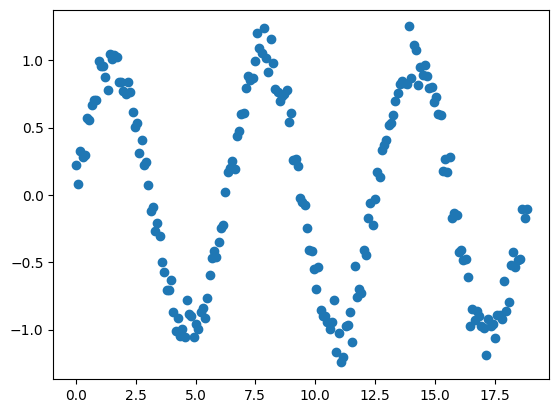

In [251]:
num_points = 200

x = np.linspace(0, 6*np.pi, num_points)
y = np.sin(x) + np.random.normal(0, 0.1, num_points)

plt.scatter(x, y)
plt.show()

In [252]:
sequence_length = 20
batch_size = num_points - sequence_length
inputs = []
targets = []

for i in range(num_points - sequence_length):
    inputs.append(y[i:i+window_size])
    targets.append(y[i+window_size])

inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch_size, window_size, 1)
targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch_size, 1)

In [253]:
input_size = 1
hidden_size = 10
output_size = 1

rnn = RNN(input_size, hidden_size, output_size)

In [254]:
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.01)

In [255]:
# Treinamento
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    predictions = rnn(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.1727900356054306
Epoch 50, Loss: 0.021180471405386925
Epoch 100, Loss: 0.018784252926707268
Epoch 150, Loss: 0.017567791044712067
Epoch 200, Loss: 0.018675215542316437
Epoch 250, Loss: 0.013893559575080872
Epoch 300, Loss: 0.012488841079175472
Epoch 350, Loss: 0.011580373160541058
Epoch 400, Loss: 0.011146601289510727
Epoch 450, Loss: 0.012489039450883865


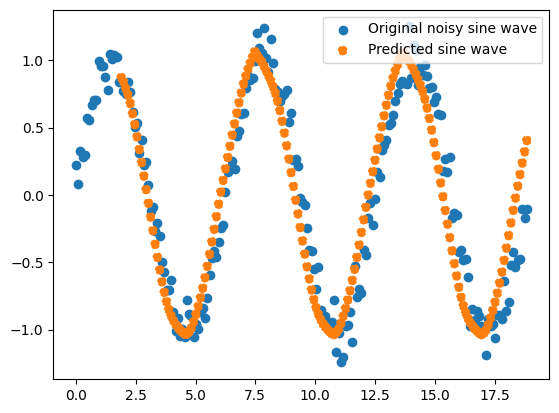

In [257]:
# Gerando predições para uma senoide
predicted_wave = []

input_seq = y[:sequence_length].reshape(1, sequence_length, 1)
input_seq = torch.tensor(input_seq, dtype=torch.float32)

for _ in range(num_points - sequence_length):
    predicted_next = rnn(input_seq)
    predicted_wave.append(predicted_next.item())

    # Arrasta a janela de entrada
    predicted_next = predicted_next.view(1, 1, 1)  # Reshape para (1, 1, 1)
    input_seq = torch.cat([input_seq[:, 1:, :], predicted_next], dim=1) # Remove o primeiro elemento e adiciona a predição

# Plota a senoide original e a predição
plt.scatter(x, y, label='Original noisy sine wave')
plt.scatter(x[sequence_length:], predicted_wave, label='Predicted sine wave', linestyle='dashed')
plt.legend()
plt.show()

In [53]:
rnn = ElmanCell(2, 3, 2)

x = torch.randn(5, 2)
h = torch.zeros(3)

for i in range(x.size(0)):
    y, h = rnn(x[i], h)
    print(f"Passo {i}")
    print(f"h = {h}")
    print(f"y = {y}")
    print()

Passo 0
h = tensor([-0.1630,  0.1214, -0.5485], grad_fn=<TanhBackward0>)
y = tensor([-0.4018, -0.1542], grad_fn=<SqueezeBackward4>)

Passo 1
h = tensor([-0.6752, -0.2303, -0.2279], grad_fn=<TanhBackward0>)
y = tensor([-0.1779, -0.3851], grad_fn=<SqueezeBackward4>)

Passo 2
h = tensor([-0.7982, -0.2051,  0.3857], grad_fn=<TanhBackward0>)
y = tensor([ 0.1030, -0.2118], grad_fn=<SqueezeBackward4>)

Passo 3
h = tensor([-0.0721,  0.3085,  0.1476], grad_fn=<TanhBackward0>)
y = tensor([-0.1071,  0.1921], grad_fn=<SqueezeBackward4>)

Passo 4
h = tensor([-0.4990, -0.3508, -0.3871], grad_fn=<TanhBackward0>)
y = tensor([-0.1506, -0.4508], grad_fn=<SqueezeBackward4>)



Epoch 0, Loss: 1.0438709259033203
Epoch 100, Loss: 0.03255458176136017
Epoch 200, Loss: 0.025797147303819656
Epoch 300, Loss: 0.01648295484483242
Epoch 400, Loss: 0.014215466566383839


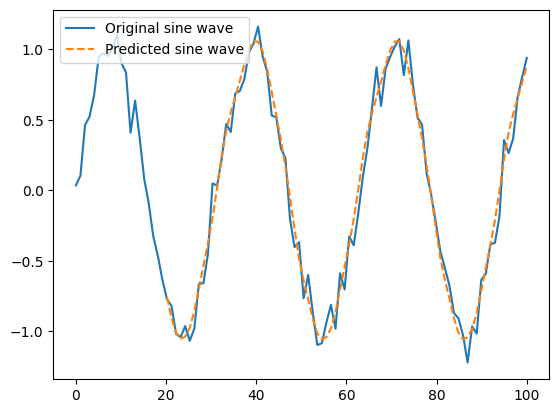

In [204]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Custom RNNCell from previous code
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_ih = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_ho = nn.Linear(hidden_size, 1, bias=False)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, hx):
        hy = torch.tanh(self.W_ih(x) + self.W_hh(hx) + self.b_h)
        return hy

# Generate a sine wave dataset
sequence_length = 20
num_samples = 100
x = np.linspace(0, 100, num_samples)
data = np.sin(.2*x) + np.random.normal(0, 0.1, num_samples)

# Prepare the dataset
input_size = 1
hidden_size = 5
batch_size = num_samples - sequence_length

inputs = []
targets = []

for i in range(batch_size):
    inputs.append(data[i:i+sequence_length])
    targets.append(data[i+sequence_length])

inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch_size, sequence_length, 1)
targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch_size, 1)

# Initialize the RNN cell
rnn_cell = MyRNNCell(input_size, hidden_size)
output_layer = nn.Linear(hidden_size, 1)  # Final layer to predict the next item
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(list(rnn_cell.parameters()) + list(output_layer.parameters()), lr=0.01)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    hx = torch.zeros(batch_size, hidden_size)  # Initial hidden state
    
    for i in range(sequence_length):
        hx = rnn_cell(inputs[:, i], hx)
    
    predictions = output_layer(hx)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generating predictions for the entire sine wave
predicted_wave = []

hx = torch.zeros(1, hidden_size)
input_seq = data[:sequence_length].reshape(1, sequence_length, 1)
input_seq = torch.tensor(input_seq, dtype=torch.float32)

for _ in range(num_samples - sequence_length):
    for i in range(sequence_length):
        hx = rnn_cell(input_seq[:, i], hx)
    predicted_next = output_layer(hx)
    predicted_wave.append(predicted_next.item())

    # Slide the window by appending the predicted value and removing the first element
    predicted_next = predicted_next.view(1, 1, 1)  # Reshape to (1, 1, 1)
    input_seq = torch.cat([input_seq[:, 1:, :], predicted_next], dim=1)

# Plot the original sine wave and the predicted sine wave
plt.plot(x, data, label='Original sine wave')
plt.plot(x[sequence_length:], predicted_wave, label='Predicted sine wave', linestyle='dashed')
plt.legend()
plt.show()


In [27]:
inputs.shape

torch.Size([80, 20, 1])

In [ ]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = MyRNNCell(input_size, hidden_size)
        
    def forward(self, x, h0):
        h = h0
        for i in range(x.size(0)):
            h = self.cell(x[i], h)
        return h

In [10]:
rnn = MyRNNCell(10, 15)

x = torch.randn(5, 10)
hx = torch.zeros(15)

outputs = []
for i in range(x.size(0)):
    hx = rnn(x[i], hx)
    outputs.append(hx)

outputs

[tensor([-0.6658,  0.8562, -0.0844, -0.8376,  0.8601,  0.5343,  0.2799,  0.3140,
         -0.6263, -0.0267,  0.5906,  0.8216,  0.4357, -0.0164,  0.1920],
        grad_fn=<TanhBackward0>),
 tensor([ 0.2759, -0.5992,  0.0460,  0.6469, -0.7227, -0.3604, -0.4971,  0.4392,
          0.6369, -0.4067, -0.3314, -0.8312,  0.4016, -0.2842,  0.1114],
        grad_fn=<TanhBackward0>),
 tensor([ 0.3867, -0.8396,  0.8433,  0.3297, -0.8691, -0.6155,  0.5825, -0.5309,
         -0.1894,  0.5673, -0.4560, -0.7423, -0.1061,  0.2354, -0.4794],
        grad_fn=<TanhBackward0>),
 tensor([-4.6839e-02,  2.4831e-01, -4.7500e-01, -1.5930e-02,  1.5756e-01,
          2.7758e-01,  6.5674e-01,  7.1004e-05,  3.0178e-01, -2.0420e-01,
         -7.5935e-02, -1.4844e-01,  1.9751e-01,  1.5905e-01, -2.3726e-01],
        grad_fn=<TanhBackward0>),
 tensor([ 0.1203, -0.3857, -0.3895, -0.7831,  0.6081, -0.6899, -0.4580, -0.2122,
         -0.0877, -0.3556,  0.5809, -0.8247, -0.4822,  0.2548, -0.8489],
        grad_fn=<TanhBack

In [2]:
rnn = nn.RNN(10, 20, 2)

input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

output.shape, hn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))

In [4]:
rnn = nn.RNNCell(10, 20)

input = torch.randn(6, 3, 10)
hx = torch.randn(3, 20)

output = []
for i in range(6):
    hx = rnn(input[i], hx)
    output.append(hx)

output

[tensor([[-0.6633, -0.3280,  0.0882,  0.1287,  0.4409,  0.3052, -0.3374,  0.4534,
           0.7693, -0.2377, -0.7475, -0.9100,  0.2237, -0.3637, -0.4020,  0.5255,
           0.6637, -0.7709, -0.1647,  0.6024],
         [-0.1848, -0.7024, -0.6322,  0.7159, -0.0869, -0.1763,  0.9161,  0.8779,
           0.7787, -0.8540,  0.8060, -0.2938, -0.2273,  0.7685, -0.1170,  0.1893,
           0.4695,  0.0324,  0.3582, -0.4790],
         [ 0.6969,  0.3404,  0.4176,  0.3540,  0.8270,  0.0147, -0.3594, -0.0437,
           0.4871,  0.8537, -0.1981, -0.4506,  0.3228,  0.6008, -0.1878,  0.8058,
           0.1528, -0.6857,  0.0742,  0.0386]], grad_fn=<TanhBackward0>),
 tensor([[-3.9440e-01,  5.1640e-01, -4.3140e-01,  4.5275e-01, -7.5984e-01,
          -6.9862e-01,  8.9616e-01,  3.3991e-01, -6.5491e-01, -7.2912e-01,
          -1.5082e-01,  6.4908e-03, -1.7203e-01, -5.1504e-01,  8.2279e-01,
          -6.2618e-01,  1.6409e-01,  2.7467e-01, -2.5838e-01, -7.8014e-01],
         [ 2.5186e-02,  2.2686e-02,  5.